# 第一步：Seurat对象的构建

### 从CellRanger输出结果构建

In [1]:
# 加载软件包，使用的镜像为
library(Seurat)
library(stringr)

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Attaching SeuratObject



In [5]:
# 创建输出文件夹
task = 'W202501050006174'
sample = 'TM2'

path = str_c("/data/work/output/DoubletFinder/",sample,"/",task, "/")
dir.create(path, recursive = TRUE, showWarnings = FALSE)

In [4]:
# 读取单个CellRanger输出结果

# file = str_c("/data/work/output/",task,"/soupX_matrix")
file = '/data/users/yuantingting/yuantingting_fd18e4ec5adc46dd89e2e5c607e9e7e3/online/output/SoupX/TM2/W202501050006174/soupX_matrix'
scrna_data <- Read10X(data.dir = file)

In [6]:
# 构建Seurat对象
seob <- CreateSeuratObject(
counts = scrna_data, #表达矩阵，稀疏或普通矩阵都可以
project = task, # 把id列改为样本名称
min.cells = 3, #去除在小于3个细胞中表达的基因
min.features = 200, # 去除只有200个以下基因表达的细胞
)
seob[['sample']]= sample

In [7]:
seob

An object of class Seurat 
23904 features across 9298 samples within 1 assay 
Active assay: RNA (23904 features, 0 variable features)

In [8]:
dim(seob)

# 第一次建库测序：
# 27861
# 12042

[1] 23904  9298

In [80]:
seob@meta.data[1:4,]

,orig.ident,nCount_RNA,nFeature_RNA,sample
,<fct>,<dbl>,<int>,<chr>
CELL1_N1,W202412240014716,2978.372,2008,EFM
CELL2_N1,W202412240014716,2134.769,1452,EFM
CELL3_N1,W202412240014716,3020.510,1861,EFM
CELL4_N1,W202412240014716,2384.682,1458,EFM


## 保存数据

In [81]:
save(seob,file = str_c(path, "SoupX_",sample,".rdata"))

# 第二步：数据的质控和过滤

In [82]:
library(tidyverse)
library(patchwork)
library(DoubletFinder)
# load(file = str_c(path, "SoupX_",sample,".rdata") ) #打开保存的数据

## 去除双胞

In [83]:
# https://lishensuo.github.io/posts/bioinfo/027%E5%8D%95%E7%BB%86%E8%83%9E%E5%88%86%E6%9E%90%E5%B7%A5%E5%85%B7--doubletfinder%E8%AF%86%E5%88%AB%E5%8F%8C%E7%BB%86%E8%83%9E/
# (1) 预处理：质控过滤 + 降维分群

# seob = PercentageFeatureSet(seob, "^MT-", col.name = "percent_mito")
seob = seob %>% 
  subset(., nFeature_RNA > 200) %>% 
  subset(., nCount_RNA > 500)   
  # subset(., percent_mito < 10) #我觉得应该在去除了双胞后再计算线粒体基因比例，因为如果是双胞的话，可能有一个细胞破了，但比例被另一个细胞稀释了

seob = seob %>%
  NormalizeData() %>%
  FindVariableFeatures() %>%
  ScaleData()

seob = seob %>% 
  RunPCA() %>% 
  RunUMAP(dims = 1:30) %>%  #RunTSNE
  FindNeighbors(dims = 1:30) %>% 
  FindClusters(resolution = 0.1)

Centering and scaling data matrix

PC_ 1 
Positive:  gene:Solyc06g075960.1, gene:Solyc04g011390.1, gene:Solyc11g007920.1, gene:Solyc02g077480.1, gene:Solyc11g072860.2, gene:Solyc10g008910.1, gene:Solyc01g086820.5, gene:Solyc01g099410.3, gene:Solyc06g074790.3, gene:Solyc06g075850.1 
	   gene:Solyc01g073970.3, gene:Solyc06g075930.1, gene:Solyc11g066430.3, gene:Solyc09g082710.3, gene:Solyc01g079110.5, gene:Solyc01g074000.4, gene:Solyc06g075830.2, gene:Solyc06g075800.1, gene:Solyc05g055430.5, gene:Solyc06g005430.1 
	   gene:Solyc06g074780.1, gene:Solyc05g054610.1, gene:Solyc09g083380.5, gene:Solyc12g056540.1, gene:Solyc11g073250.2, gene:Solyc06g005420.1, gene:Solyc09g010400.3, gene:Solyc01g100030.5.1, gene:Solyc12g005270.2, gene:Solyc11g072840.1 
Negative:  gene:Solyc03g034220.3, gene:Solyc03g098780.2, gene:Solyc01g006400.4, gene:Solyc07g007755.2, gene:Solyc07g047850.3, gene:Solyc07g066150.1, gene:Solyc02g065400.3, gene:Solyc08g006930.3, gene:Solyc02g070940.1, gene:Solyc09g084480.3 
	   ge

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12633
Number of edges: 474487

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9592
Number of communities: 7
Elapsed time: 2 seconds


In [84]:
pdf(str_c(path, "/umap_DoubletFinder_",sample,".pdf"), height = 8, width = 10)

DimPlot(seob, reduction = "umap", group.by = "seurat_clusters")

dev.off()

png 
  2

[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
NULL


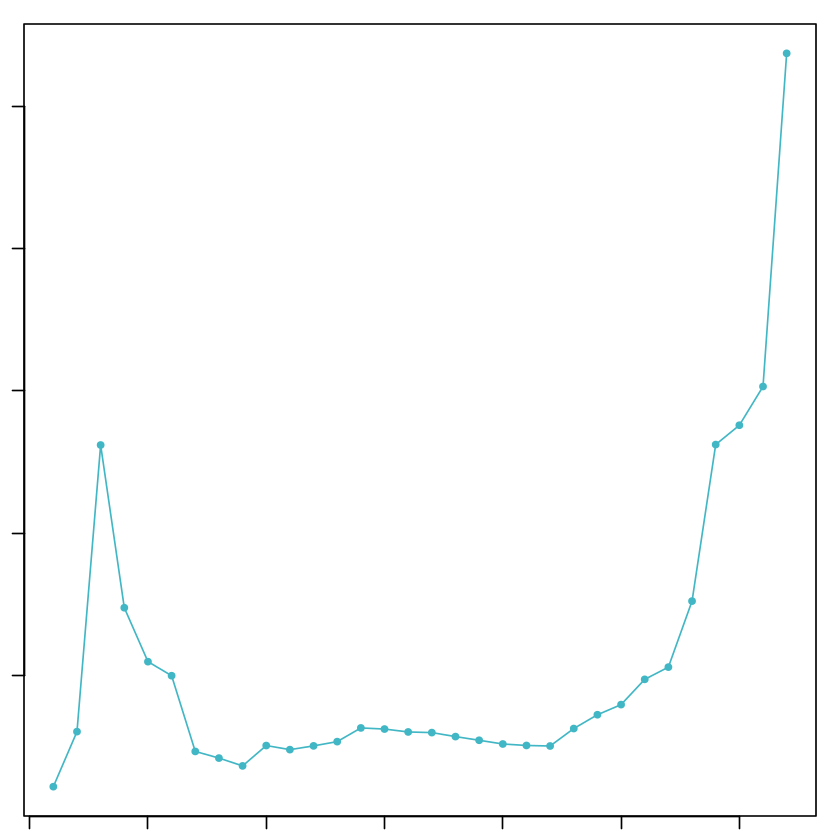

In [85]:
# (2) DoubletFinder分析

# 首先获得最佳的pK值
sweep.res.list <- paramSweep_v3(seob, PCs = 1:30, sct = FALSE)
sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
bcmvn <- find.pK(sweep.stats)
pk_best = bcmvn %>% 
  dplyr::arrange(desc(BCmetric)) %>% 
  dplyr::pull(pK) %>% 
  .[1] %>% as.character() %>% as.numeric()
# [1] 0.3

In [86]:
pdf(str_c(path, "/bcmvn_DoubletFinder_",sample,".pdf"), height = 8, width = 12)

ggplot(bcmvn, aes(x=pK, y=BCmetric, group=1)) + 
  geom_point() +
  geom_line()
# 最佳的pK值是折现的最高点对应的0.03

dev.off()

png 
  2

In [87]:
# 然后估算出双细胞群中，homotypic doublets的比例(optional)
annotations <- seob$seurat_clusters
homotypic.prop <- modelHomotypic(annotations)  
# [1] 0.3159673

In [88]:
# 根据10X V3.1,对于8K+的单细胞数据，期望的双细胞占比为7%左右,这个网址有个表格按照细胞的数量来估计双胞率https://blog.csdn.net/zfyyzhys/article/details/142171565
nExp_poi <- round(0.07*nrow(seob@meta.data))        #586，8000个细胞的双胞率是0.039，16000个细胞的双胞率是0.076，TM0有29000个细胞，还是按照0.07吧，保险一点
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop)) #473

In [89]:
# 最后根据上述参数(pN=0.25, pK=0.3, nExp=0.07), 识别出双细胞
seob <- doubletFinder_v3(seob, PCs = 1:30, 
                        pN = 0.25, pK = pk_best, nExp = nExp_poi, # nExp = nExp_poi.adj, 
                        reuse.pANN = FALSE, sct = FALSE)

[1] "Creating 4211 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [90]:
seob@meta.data[1:4,]

,orig.ident,nCount_RNA,nFeature_RNA,sample,RNA_snn_res.0.1,seurat_clusters,pANN_0.25_0.3_884,DF.classifications_0.25_0.3_884
,<fct>,<dbl>,<int>,<chr>,<fct>,<fct>,<dbl>,<chr>
CELL1_N1,W202412240014716,2978.372,2008,EFM,1,1,0.2113596,Singlet
CELL2_N1,W202412240014716,2134.769,1452,EFM,1,1,0.1753414,Singlet
CELL3_N1,W202412240014716,3020.510,1861,EFM,1,1,0.2281813,Singlet
CELL4_N1,W202412240014716,2384.682,1458,EFM,1,1,0.2388680,Singlet


In [91]:
# # 从meta.data中获取指定列名的值
name = colnames(seob@meta.data)[[8]]

In [92]:
pdf(str_c(path, "/Doubletcounts_DoubletFinder_",sample,".pdf"), height = 10, width = 12)

DimPlot(seob, reduction = "umap", 
        group.by = name)

VlnPlot(seob, group.by = name, 
        features = c("nCount_RNA", "nFeature_RNA"), 
        pt.size = 0, ncol = 2)

dev.off()

png 
  2

In [93]:
# load(file = str_c(path, "/DoubletFinder_",sample,".rdata"))

In [94]:
dim(seob) #去双胞前有29681个基因，12633个细胞

[1] 29681 12633

In [95]:
# 取出单胞

seob <- seob[, seob@meta.data[[name]] == "Singlet"]


In [96]:
dim(seob) #去除单胞后还有11749个细胞，比原来少了884个细胞

[1] 29681 11749

## 添加线粒体和叶绿体信息

In [99]:
seob[["percent.mt"]] <- PercentageFeatureSet(
  seob,
  pattern = "^MT" #获取线粒体基因列表
  # features = mt_genes
)

seob[["percent.cp"]] <- PercentageFeatureSet(
  seob,
  pattern = "^CP" #获取叶绿体基因列表
  # features = mt_genes
)

In [100]:
seob@meta.data[1:4,]

,orig.ident,nCount_RNA,nFeature_RNA,sample,RNA_snn_res.0.1,seurat_clusters,pANN_0.25_0.3_884,DF.classifications_0.25_0.3_884,percent.cp
,<fct>,<dbl>,<int>,<chr>,<fct>,<fct>,<dbl>,<chr>,<dbl>
CELL1_N1,W202412240014716,2978.372,2008,EFM,1,1,0.2113596,Singlet,0.00000000
CELL2_N1,W202412240014716,2134.769,1452,EFM,1,1,0.1753414,Singlet,0.04099547
CELL3_N1,W202412240014716,3020.510,1861,EFM,1,1,0.2281813,Singlet,0.00000000
CELL4_N1,W202412240014716,2384.682,1458,EFM,1,1,0.2388680,Singlet,0.03615260


## 添加细胞周期

Seurat可以对细胞周期进行打分，从而推断细胞周期

In [101]:
# 读取文件
library(readr)
ccgenes_s <- read.table(
  file = "/data/work/input/DoubletFinder/cell_cycles_ITAG4.1_S_241212.csv",
  sep = ",",
  header = T)

ccgenes_g2m <- read.table(
  file = "/data/work/input/DoubletFinder/cell_cycles_ITAG4.1_G2M_241212.csv",
  sep = ",",
  header = T)

cc.genes$s.genes <- ccgenes_s$Gene_SL4.0
cc.genes$g2m.genes <- ccgenes_g2m$Gene_SL4.0

In [102]:
seob <- CellCycleScoring(
  seob,
  s.features = cc.genes$s.genes,
  g2m.features = cc.genes$g2m.genes
)

Warning message:
"The following features are not present in the object: gene:Solyc04g049530.1, not searching for symbol synonyms"


In [103]:
seob@meta.data[1:4,]

,orig.ident,nCount_RNA,nFeature_RNA,sample,RNA_snn_res.0.1,seurat_clusters,pANN_0.25_0.3_884,DF.classifications_0.25_0.3_884,percent.cp,S.Score,G2M.Score,Phase
,<fct>,<dbl>,<int>,<chr>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
CELL1_N1,W202412240014716,2978.372,2008,EFM,1,1,0.2113596,Singlet,0.00000000,0.003521321,-0.03459725,S
CELL2_N1,W202412240014716,2134.769,1452,EFM,1,1,0.1753414,Singlet,0.04099547,-0.055136145,0.30412381,G2M
CELL3_N1,W202412240014716,3020.510,1861,EFM,1,1,0.2281813,Singlet,0.00000000,0.031769494,-0.12607667,S
CELL4_N1,W202412240014716,2384.682,1458,EFM,1,1,0.2388680,Singlet,0.03615260,0.063668711,-0.10589261,S


## 可视化

### 箱线图

In [104]:
pdf(str_c(path, "/VlnPlot_",sample,".pdf"), height = 8, width = 12)

VlnPlot(
  seob,
  features = c("nFeature_RNA","nCount_RNA"),
  group.by = "sample",
  log = T,
  pt.size = 0.1
)

dev.off()

png 
  2

### 山峦图

In [105]:
pdf(str_c(path, "/RidgePlot_",sample,".pdf"), height = 4, width = 8)

RidgePlot(
  object = seob,
  features = c("nFeature_RNA","nCount_RNA"),
  log = T,
  ncol = 1,
  group.by = "sample"
)

dev.off()

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Picking joint bandwidth of 0.02

Picking joint bandwidth of 0.0324



png 
  2

### 散点图

In [106]:
pdf(str_c(path, "/FeatureScatter_",sample,".pdf"), height = 4, width = 12)

p1 <- FeatureScatter(
  seob,
  feature1 = "nCount_RNA",
  feature2 = "nFeature_RNA",
  group.by = "sample"
)

p2 <- FeatureScatter(
  seob,
  feature1 = "nCount_RNA",
  feature2 = "percent.mt",
  group.by = "sample"
)

p3 <- FeatureScatter(
  seob,
  feature1 = "nCount_RNA",
  feature2 = "percent.cp",
  group.by = "sample"
)
p1+p2+p3
dev.off()

png 
  2

In [107]:
# 过滤线粒体和叶绿体基因比例过高的细胞

seob <- subset(
    seob,
    subset = percent.mt <1 &
    percent.cp < 1
)

In [108]:
save(seob,file = str_c(path, "/Singlet_",sample,".rdata"))

In [109]:
seob <- SCTransform(
    seob,
    variable.features.n = 3000,
    verbose = FALSE
)

PC_ 1 
Positive:  gene:Solyc01g099410.3, gene:Solyc04g011390.1, gene:Solyc01g086820.5, gene:Solyc06g074790.3, gene:Solyc01g073970.3, gene:Solyc05g055430.5, gene:Solyc10g008910.1, gene:Solyc11g007920.1, gene:Solyc02g077480.1, gene:Solyc06g075960.1 
	   gene:Solyc09g010400.3, gene:Solyc09g083380.5, gene:Solyc01g074000.4, gene:Solyc11g072860.2, gene:Solyc11g066430.3, gene:Solyc01g079110.5, gene:Solyc06g075830.2, gene:Solyc06g005420.1, gene:Solyc06g075850.1, gene:Solyc06g074780.1 
	   gene:Solyc06g075930.1, gene:Solyc06g075800.1, gene:Solyc11g073250.2, gene:Solyc11g073260.2, gene:Solyc06g005430.1, gene:Solyc11g072840.1, gene:Solyc09g074300.1, gene:Solyc05g054610.1, gene:Solyc01g086800.4, gene:Solyc02g038690.1 
Negative:  gene:Solyc01g006400.4, gene:Solyc07g006380.3, gene:Solyc07g007750.3, gene:Solyc06g074820.3, gene:Solyc11g020960.2, gene:Solyc03g098780.2, gene:Solyc07g007755.2, gene:Solyc09g084480.3, gene:Solyc07g043420.3, gene:Solyc03g034220.3 
	   gene:Solyc07g047850.3, gene:Solyc06g076

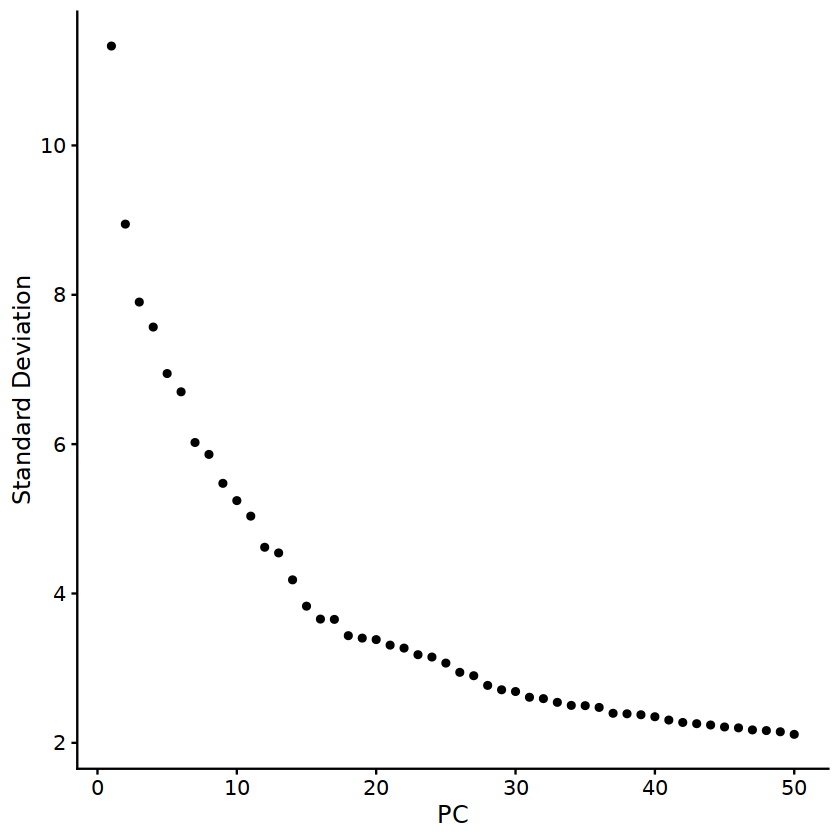

In [110]:
seob <- RunPCA(seob)
ElbowPlot(seob,ndims = 50)

In [111]:
seob <- RunTSNE(seob,
                #使用多少个PC，如果是SCT建议多一些PC
                dims = 1:30)

In [112]:
seob <- RunUMAP(seob,
                #使用多少个PC，如果是SCT建议多一些PC
                dims = 1:30)

21:36:51 UMAP embedding parameters a = 0.9922 b = 1.112

21:36:51 Read 11749 rows and found 30 numeric columns

21:36:51 Using Annoy for neighbor search, n_neighbors = 30

21:36:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:36:53 Writing NN index file to temp file /tmp/Rtmpl0TBxc/file16c4de358c5

21:36:53 Searching Annoy index using 1 thread, search_k = 3000

21:36:57 Annoy recall = 100%

21:36:58 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:36:59 Initializing from normalized Laplacian + noise (using irlba)

21:37:01 Commencing optimization for 200 epochs, with 516578 positive edges

21:37:17 Optimization finished



In [113]:
#找邻居
seob <- FindNeighbors(
  seob,
  k.param = 20, #找离自己最近的20个基因，最低设置5个
  dims = 1:30
)

Computing nearest neighbor graph

Computing SNN



In [114]:
#聚类，请调节r的数值，使# Number of communities的结果是 11 

r = 0.3
seob <- FindClusters(
  seob,
  resolution = r, #值越大，cluster越多
  random.seed = 1, #设置可避免同样的参数每次跑出来的结果不一样
                     )

# Number of communities: 11 这里暂时选定11个cluster

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11749
Number of edges: 433961

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9094
Number of communities: 11
Elapsed time: 2 seconds


In [115]:
pdf(str_c(path, "/Cluster_",sample,"_r", r, ".pdf"), height = 8, width = 24)

p1 <- DimPlot(
  seob,
  reduction = "pca",
  group.by = "seurat_clusters",
  label = T
) 
p2 <- DimPlot(
  seob,
  reduction = "tsne",
  group.by = "seurat_clusters",
  label = T
) 
p3 <- DimPlot(
  seob,
  reduction = "umap",
  group.by = "seurat_clusters",
  label = T
) 

p1+p2+p3

dev.off()

png 
  2

In [116]:
# 试试harmony效果，参考http://www.biocloudservice.com/wordpress/?p=60391
# 使用RunHarmony函数去批次
#按照样本组别去批次，这里使用了管道函数%>%，即把函数左边的值发给右边做后续处理。
# Harmony需要输入低维空间的坐标值（embedding），一般使用PCA的降维结果。Harmony导入PCA的降维数据后，会采用soft k-means clustering算法将细胞聚类。
# 因为这里只有一次测序的结果，之前检测过没有啥批次效应，所以暂时不做整合
# library(harmony)
# seob2 = seob1 %>% RunHarmony("sample", plot_convergence = TRUE)

In [117]:
save(seob,file = str_c(path, "/Cluster_r", r, "_", sample,".rdata"))

In [118]:
saveRDS(seob,file = str_c(path, "/Cluster_r", r, "_", sample,".rds"))